<h1><font size="6">Cataract Classification</font></h1>

In this notebook, uses two retina datasets to challenge the cataract classification.

## Contents
* [Import libraries](#import)
* [Set configurations and read metadata](#set)
* [Process Cataract dataset](#process1)
* [Process Ocular disease recognition dataset](#process2)
* [Create datasets](#create)
* [Build the model(1)](#build1)
* [Build the model(2)](#build2)

## Import libraries <a name="import"> </a>

In [1]:
%pip install -q efficientnet


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade tensorflow


In [4]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [5]:
import tensorflow as tf
# Yeni kullanım
default_graph = tf.compat.v1.get_default_graph()


In [6]:
pip install kaggle


In [7]:
mkdir C:\Users\busez\.kaggle


A subdirectory or file C:\Users\busez\.kaggle already exists.


In [8]:
!kaggle kernels output koshirosato/cataract-classification-with-two-retina-datasets -p /path/to/dest

Kernel log downloaded to /path/to/dest\cataract-classification-with-two-retina-datasets.log 


## Set configurations and read metadata <a name="set"> </a>

In [96]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

# cataract dataset
IMG_ROOT = 'cataractdataset/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
#OCU_IMG_ROOT = os.path.join("archive(1)", "ODIR-5K", "ODIR-5K", "TrainingImages")
OCU_IMG_ROOT ="archive (1)/ODIR-5K/ODIR-5K/TrainingImages/" 
ocu_df = pd.read_excel("archive (1)\ODIR-5K\ODIR-5K\data.xlsx")

In [99]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## Process Cataract dataset <a name="process1"> </a>

In [100]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

,paths,cataract
0,cataractdataset/dataset\1_normal/NL_001.png,0
1,cataractdataset/dataset\1_normal/NL_002.png,0
2,cataractdataset/dataset\1_normal/NL_003.png,0
3,cataractdataset/dataset\1_normal/NL_004.png,0
4,cataractdataset/dataset\1_normal/NL_005.png,0
...,...,...
596,cataractdataset/dataset\3_retina_disease/Retin...,0
597,cataractdataset/dataset\3_retina_disease/Retin...,0
598,cataractdataset/dataset\3_retina_disease/Retin...,0
599,cataractdataset/dataset\3_retina_disease/Retin...,0


In [101]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
cataract
0    601
Name: count, dtype: int64


## Process Ocular disease recognition dataset <a name="process2"> </a>

In [102]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [103]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0
    
ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [104]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [105]:
le_df.head()

,cataract,paths
0,1,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/0_l...
1,0,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/1_l...
2,0,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/2_l...
3,0,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/3_l...
4,0,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/4_l...


In [106]:
re_df.head()

,cataract,paths
0,0,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/0_r...
1,0,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/1_r...
2,0,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/2_r...
3,0,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/3_r...
4,0,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/4_r...


In [107]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
cataract
0    3341
1     159
Name: count, dtype: int64

Number of right eye images
cataract
0    3346
1     154
Name: count, dtype: int64


There is a large bias in the dataset. So make it even.

In [108]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
cataract
1    159
0    159
Name: count, dtype: int64

Number of right eye images
cataract
1    154
0    154
Name: count, dtype: int64


In [109]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/0_l...
81,1,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/81_...
103,1,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/103...
119,1,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/119...
253,1,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/254...


## Create datasets <a name="create"> </a>
Combine the two metadata and use them to load the image data and create datasets.

In [110]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

,paths,cataract
0,cataractdataset/dataset\1_normal/NL_001.png,0
1,cataractdataset/dataset\1_normal/NL_002.png,0
2,cataractdataset/dataset\1_normal/NL_003.png,0
3,cataractdataset/dataset\1_normal/NL_004.png,0
4,cataractdataset/dataset\1_normal/NL_005.png,0
...,...,...
1222,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/943...,0
1223,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/294...,0
1224,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/395...,0
1225,archive (1)/ODIR-5K/ODIR-5K/TrainingImages/199...,0


In [111]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                      
                                    stratify=train_df['cataract'])

In [112]:
train_df['paths']

1043    archive (1)/ODIR-5K/ODIR-5K/TrainingImages/221...
894     archive (1)/ODIR-5K/ODIR-5K/TrainingImages/614...
548     cataractdataset/dataset\3_retina_disease/Retin...
538     cataractdataset/dataset\3_retina_disease/Retin...
1146    archive (1)/ODIR-5K/ODIR-5K/TrainingImages/817...
                              ...                        
922     archive (1)/ODIR-5K/ODIR-5K/TrainingImages/188...
539     cataractdataset/dataset\3_retina_disease/Retin...
440     cataractdataset/dataset\2_glaucoma/Glaucoma_04...
1080    archive (1)/ODIR-5K/ODIR-5K/TrainingImages/168...
5             cataractdataset/dataset\1_normal/NL_006.png
Name: paths, Length: 833, dtype: object

In [113]:
print(df.columns)

Index(['paths', 'cataract'], dtype='object')


In [114]:
# Örnek olarak birkaç dosya yolunu kontrol etme
for path in train_df['paths'].iloc[:5]:  # İlk 5 dosya yolunu kontrol ediyoruz, değiştirilebilir.
    print(path)

archive (1)/ODIR-5K/ODIR-5K/TrainingImages/2216_right.jpg
archive (1)/ODIR-5K/ODIR-5K/TrainingImages/614_left.jpg
cataractdataset/dataset\3_retina_disease/Retina_048.png
cataractdataset/dataset\3_retina_disease/Retina_038.png
archive (1)/ODIR-5K/ODIR-5K/TrainingImages/817_right.jpg


In [115]:
import os

for path in df['paths']:
    if os.path.exists(path):
        print(f"{path} dosya yolu doğru ve dosya mevcut.")
    else:
        print(f"{path} dosya yolu doğru değil veya dosya mevcut değil.")

cataractdataset/dataset\1_normal/NL_001.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_002.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_003.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_004.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_005.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_006.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_007.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_008.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_009.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_010.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_011.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_012.png dosya yolu doğru ve dosya mevcut.
cataractdataset/dataset\1_normal/NL_013.png dosya yolu doğru ve 

In [116]:
from PIL import Image
import os
import numpy as np
import pandas as pd

def create_datasets(df, img_width, img_height):
    imgs = []
    for path in df['paths']:
        with Image.open(path) as img:
            img = img.convert("RGB")  # Görüntüyü RGB formatına dönüştürme
            img = img.resize((img_width, img_height))
            img_np = np.array(img)
            imgs.append(img_np)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df

# Örnek IMG_WIDTH ve IMG_HEIGHT değerleri
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Veri setlerini oluşturma ve normalleştirme
train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

# Verileri normalize etme
train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0


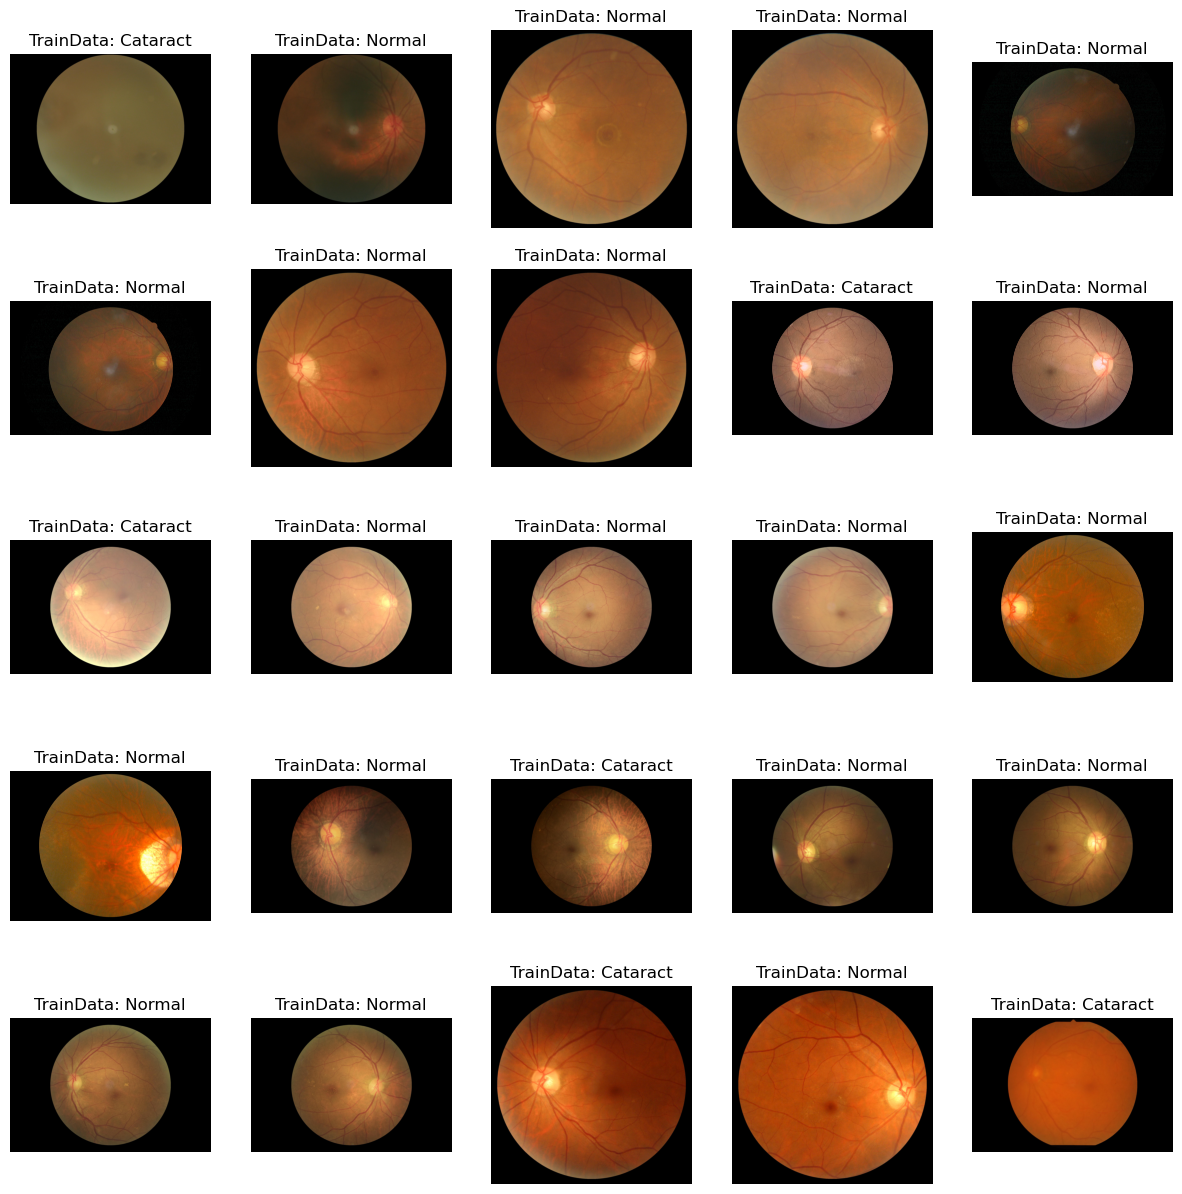

In [120]:
import os
from PIL import Image
import matplotlib.pyplot as plt

f, ax = plt.subplots(5, 5, figsize=(15, 15))
norm_list = list(train_df[train_df.columns[0]][:25])

directory = "archive (1)/ODIR-5K/ODIR-5K/TrainingImages/" 
file_list = os.listdir(directory)

for i, file_name in enumerate(file_list[:25]):
    file_path = os.path.join(directory, file_name)
    if os.path.isfile(file_path):
        # Dosya varsa yapılacak işlemler buraya gelecek
        try:
            img = Image.open(file_path)
            img_np = np.array(img)
            
            ax[i // 5, i % 5].imshow(img_np)
            ax[i // 5, i % 5].axis('off')

            if norm_list[i] == 1:
                ax[i // 5, i % 5].set_title('TrainData: Normal')
            else:
                ax[i // 5, i % 5].set_title('TrainData: Cataract')

        except (IOError, OSError) as e:
            print(f"Hata: {e} - {file_path}")
    else:
        print(f"Dosya bulunamadı: {file_path}")

plt.show()


In [121]:
print(train_df.head())
print(train_df.columns)


          0      1
1043  False   True
894    True  False
548    True  False
538    True  False
1146   True  False
Index([0, 1], dtype='int64')


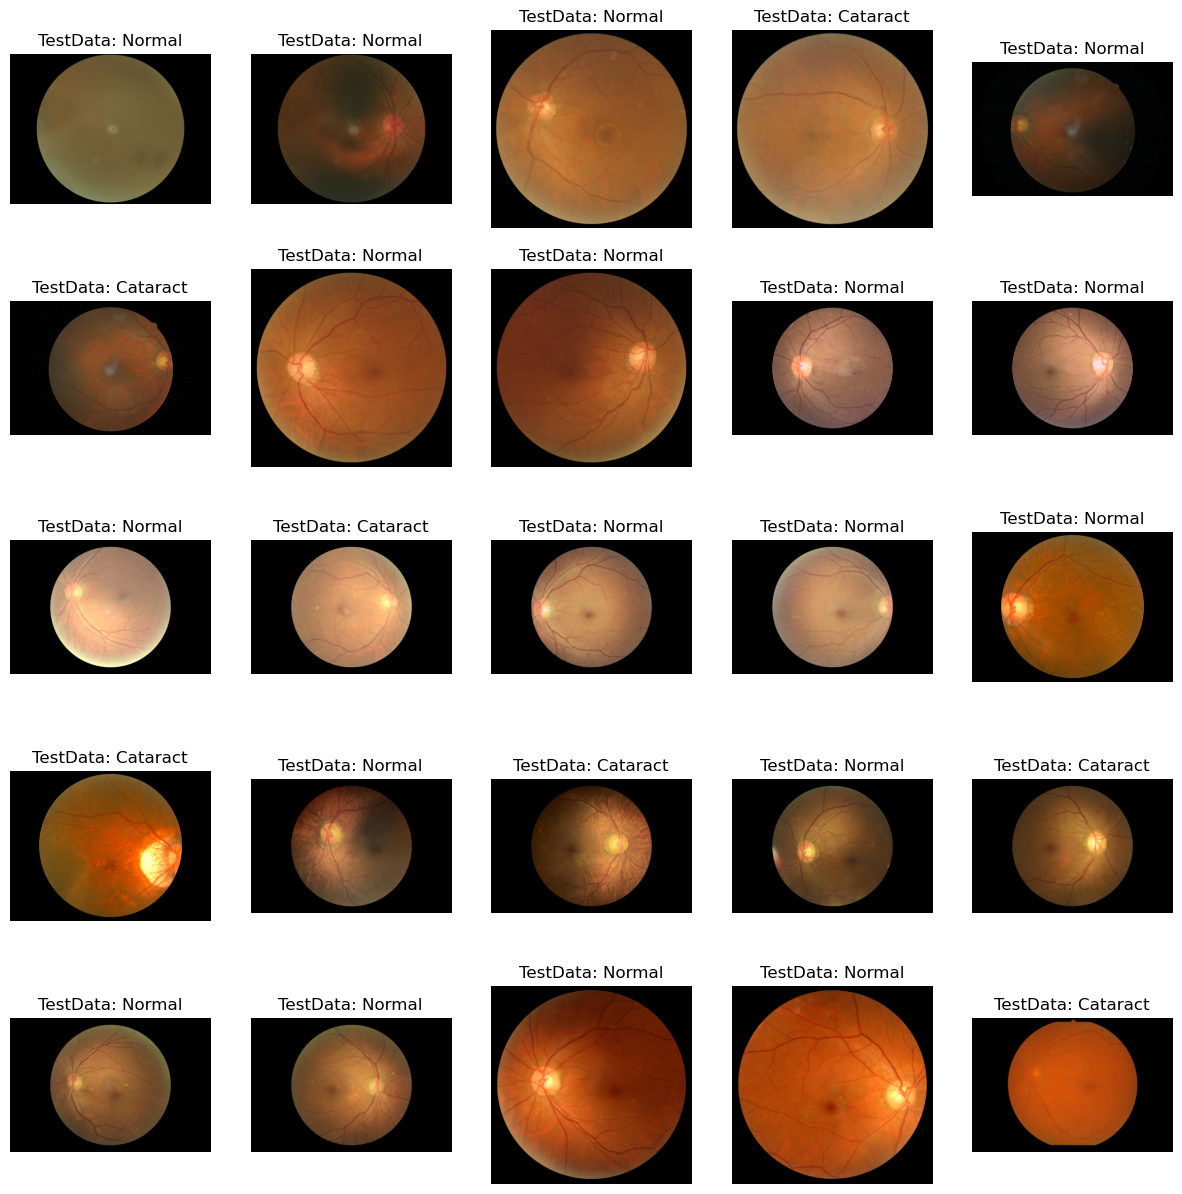

In [122]:
f, ax = plt.subplots(5, 5, figsize=(15, 15))
norm_list = list(test_df[test_df.columns[0]][:25])  # Test verisi için uygun sütunun seçimi

directory1 = r"archive(1)\\ODIR-5K\\ODIR-5K\\TestingImages\\"  
file_list = os.listdir(directory)

for i, file_name in enumerate(file_list[:25]):
    file_path = os.path.join(directory, file_name)
    if os.path.isfile(file_path):
        # Dosya varsa yapılacak işlemler buraya gelecek
        try:
            img = Image.open(file_path)
            img_np = np.array(img)
            
            ax[i // 5, i % 5].imshow(img_np)
            ax[i // 5, i % 5].axis('off')

            if norm_list[i] == 1:
                ax[i // 5, i % 5].set_title('TestData: Normal')
            else:
                ax[i // 5, i % 5].set_title('TestData: Cataract')

        except (IOError, OSError) as e:
            print(f"Hata: {e} - {file_path}")
    else:
        print(f"Dosya bulunamadı: {file_path}")

plt.show()


## Build the model(1) <a name="build1"> </a>

In [123]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [124]:
pip install tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [125]:
from tensorflow_addons.activations import mish


C:\Users\busez\anaconda33\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\busez\anaconda33\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure 

In [126]:
#modeli tanımlama
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 42, 42, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 16)       

Use some image data augmentation to generate randomly augmented image data from the ImageDataGenerator Object.

In [127]:
#modelin özetini görüntüleme
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100

26/26 [==============================] - 7s 184ms/step - loss: 1.0418 - accuracy: 0.7071 - val_loss: 0.6093 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 5s 179ms/step - loss: 0.9713 - accuracy: 0.7155 - val_loss: 0.5888 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 5s 183ms/step - loss: 0.7260 - accuracy: 0.7623 - val_loss: 0.5261 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 5s 191ms/step - loss: 0.5707 - accuracy: 0.7935 - val_loss: 0.5160 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 5s 186ms/step - loss: 0.6607 - accuracy: 0.7623 - val_loss: 0.6291 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 5s 183ms/step - loss: 0.5973 - accuracy: 0.7791 - val_loss: 0.5139 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 5s 184ms/s

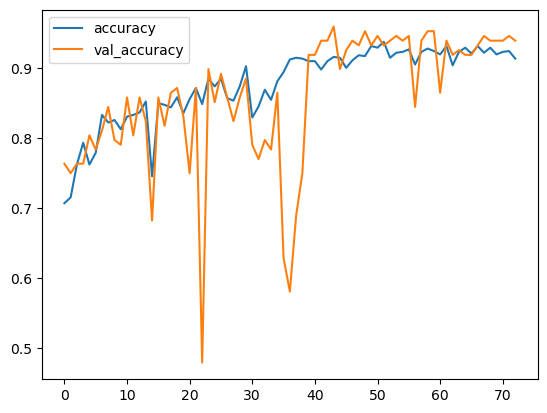

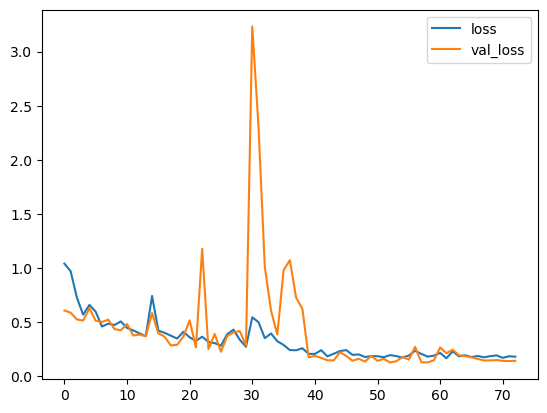

In [128]:
#modeli eğitme
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [129]:
model.evaluate(test_imgs, test_df) 

8/8 [==============================] - 0s 17ms/step - loss: 0.1652 - accuracy: 0.9350


[0.1652107834815979, 0.934959352016449]

## Build the model(2) <a name="build2"> </a>
We will train using a model that has been pre-trained.

In [130]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnet-b0 (Functiona  (None, 4, 4, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4052126 (15.46 MB)
Trainable params: 4010110 (15.30 MB)
Non-trainable params: 42016 (164.12 KB)
_________________________________________________________________


In [131]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
26/26 [==============================] - 34s 615ms/step - loss: 0.6949 - accuracy: 0.5510 - val_loss: 0.6282 - val_accuracy: 0.6554 - lr: 3.0000e-06
Epoch 2/100
26/26 [==============================] - 14s 551ms/step - loss: 0.6604 - accuracy: 0.6122 - val_loss: 0.5986 - val_accuracy: 0.7432 - lr: 3.0000e-06
Epoch 3/100
26/26 [==============================] - 14s 549ms/step - loss: 0.6061 - accuracy: 0.6867 - val_loss: 0.5586 - val_accuracy: 0.7838 - lr: 3.0000e-06
Epoch 4/100
26/26 [==============================] - 14s 552ms/step - loss: 0.5797 - accuracy: 0.7323 - val_loss: 0.5302 - val_accuracy: 0.7973 - lr: 3.0000e-06
Epoch 5/100
26/26 [==============================] - 14s 548ms/step - loss: 0.5500 - accuracy: 0.7647 - val_loss: 0.5060 - val_accuracy: 0.8041 - lr: 3.0000e-06
Epoch 6/100
26/26 [==============================] - 15s 557ms/step - loss: 0.5044 - accuracy: 0.7995 - val_loss: 0.4909 - val_accuracy: 0.7973 - lr: 3.0000e-06
Epoch 7/100
26/26 [===============

Epoch 52/100
26/26 [==============================] - 15s 555ms/step - loss: 0.1751 - accuracy: 0.9532 - val_loss: 0.2189 - val_accuracy: 0.9257 - lr: 3.0000e-06
Epoch 53/100
26/26 [==============================] - 14s 552ms/step - loss: 0.1915 - accuracy: 0.9520 - val_loss: 0.2183 - val_accuracy: 0.9324 - lr: 3.0000e-06
Epoch 54/100
26/26 [==============================] - 15s 554ms/step - loss: 0.1700 - accuracy: 0.9604 - val_loss: 0.2160 - val_accuracy: 0.9257 - lr: 3.0000e-06
Epoch 55/100
26/26 [==============================] - 14s 552ms/step - loss: 0.1714 - accuracy: 0.9604 - val_loss: 0.2135 - val_accuracy: 0.9392 - lr: 3.0000e-06
Epoch 56/100
26/26 [==============================] - 14s 552ms/step - loss: 0.1634 - accuracy: 0.9616 - val_loss: 0.2107 - val_accuracy: 0.9392 - lr: 3.0000e-06
Epoch 57/100
26/26 [==============================] - 15s 556ms/step - loss: 0.1757 - accuracy: 0.9544 - val_loss: 0.2094 - val_accuracy: 0.9392 - lr: 3.0000e-06
Epoch 58/100
26/26 [========

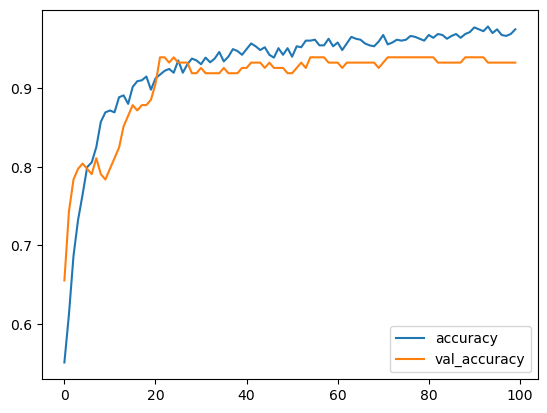

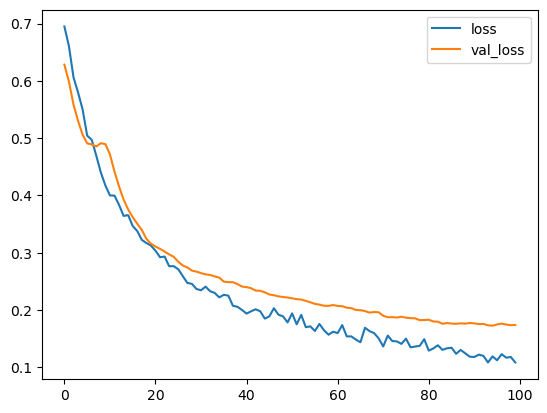

In [132]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [133]:
model.evaluate(test_imgs, test_df) 

8/8 [==============================] - 1s 111ms/step - loss: 0.1356 - accuracy: 0.9675


[0.13561499118804932, 0.9674796462059021]

In [134]:
# Örnek olarak, TensorFlow Keras ile modeli kaydetme
from tensorflow.keras.models import load_model

model.save('cataract-classification-with-two-retina-datasets')  # Modeli kaydetme


INFO:tensorflow:Assets written to: cataract-classification-with-two-retina-datasets\assets


INFO:tensorflow:Assets written to: cataract-classification-with-two-retina-datasets\assets


In [135]:
# Kaydedilmiş modeli yükleme
loaded_model = load_model('cataract-classification-with-two-retina-datasets')

# Tahminler yapma
#predictions = loaded_model.predict(new_data)


In [4]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Modeli yükleme
model_path = "cataract-classification-with-two-retina-datasets"  # eğittiğiniz modelin dosya yolunu buraya yazın
model = load_model(model_path)

# Kamera başlatma
cap = cv2.VideoCapture(0)  # 0, bilgisayarınızda mevcut olan bir kamera demektir

while True:
    # Kameradan bir kare al
    ret, frame = cap.read()

    # Yüz tespiti için bir yüz tanıma sınıfı kullanabilirsiniz (örneğin, OpenCV'deki CascadeClassifier)
    # Bu sadece bir örnek, daha gelişmiş yöntemler de kullanabilirsiniz
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            # Göz bölgesini çıkartma
            eye_roi = frame[y + ey:y + ey + eh, x + ex:x + ex + ew]

            # Göz bölgesini modelinize uygun formata getirme, örneğin boyutlandırma ve normalizasyon
            target_size = (128, 128)
            resized_eye = cv2.resize(eye_roi, target_size)
            normalized_eye = resized_eye / 255.0

            # Modelinize tahmin yaptırma
            processed_eye = np.expand_dims(normalized_eye, axis=0)
            prediction = model.predict(processed_eye)

            # Tahmin sonuçlarını işleme
            if prediction[0][0] > 0.5:
                label = "Sağlam"
            else:
                label = "Hasta"

            # Görüntü üzerine etiketi yazdırma
            cv2.putText(frame, label, (x + ex, y + ey - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Göz bölgesini çerçeve içine alma
            cv2.rectangle(frame, (x + ex, y + ey), (x + ex + ew, y + ey + eh), (0, 255, 0), 2)

    # Görüntüyü ekrana gösterme
    cv2.imshow('Frame', frame)

    # Çıkış için klavyeden 'q' tuşuna basıldığında döngüyü kır
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Kamerayı serbest bırakma ve pencereyi kapatma
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
from tensorflow.keras.models import load_model

# Modeli yükleme
loaded_model = load_model('cataract-classification-with-two-retina-datasets')

# Cataract tanıma işlevi
def cataract_tani_yap(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Modelin beklentisi doğrultusunda boyutu ayarla
    image_array = np.expand_dims(np.array(image), axis=0) / 255.0  # Normalizasyon

    # Cataract tanıma işlemi
    prediction = loaded_model.predict(image_array)
    result = "Cataract" if prediction[0][0] > 0.5 else "Normal"

    return result

# Resmi açma ve tanıma işlemleri
def open_and_analyze_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.png;*.jpg;*.jpeg;*.bmp")])
    if file_path:
        # Cataract tanıma işlemi
        result = cataract_tani_yap(file_path)

        # Tkinter penceresine resmi gösterme
        image = Image.open(file_path)
        image.thumbnail((300, 300))  # Resmi küçültme
        tk_image = ImageTk.PhotoImage(image)
        label_image.config(image=tk_image)
        label_image.image = tk_image

        # Sonuçları görüntüleme
        result_label.config(text=f"Sonuç: {result}")

# Tkinter penceresi oluşturma
root = tk.Tk()
root.title("Cataract Tanıma Uygulaması")

# Resim seçme düğmesi
open_button = tk.Button(root, text="Resim Seç ve Analiz Et", command=open_and_analyze_image)
open_button.pack(pady=10)

# Resim gösterme alanı
label_image = tk.Label(root)
label_image.pack(pady=10)

# Tanıma sonuçlarını gösterme etiketi
result_label = tk.Label(root, text="Sonuç: ")
result_label.pack(pady=10)

# Pencereyi açma
root.mainloop()
